<img src="altiscale_logo.png" width=300 height=300 align=center>

# Welcome to Altiscale Data Cloud

## First let's print the spark context

In [1]:
print sc

## Computing Pi value

In [2]:
from operator import add
partitions = 5
n = 100000 * partitions
from pandas import *
def f(_):
    from random import random
    x = random() * 2 - 1
    y = random() * 2 - 1
    return 1 if x**2 + y**2 < 1 else 0
count = sc.parallelize(range(1, n+1), partitions).map(f).reduce(add)
print("Pi is roughly %f" % (4.0 * count / n))

Pi is roughly 3.143880


## Analyzing Bay Area bike share trips

We'll analyze the Bay Area bike share trips' data for the period of September 2014 to August 2015. 

This dataset is available for download at http://www.bayareabikeshare.com/open-data. 

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

### Let's load a sample dataset into Spark dataframe 

The file "201508_trip_data.json" should be copied to your HDFS home folder. The file can be found in the git repo. To copy to hdfs, you can hdfs dfs shell. For example: hdfs dfs -copyFromLocal /local/path/to/201508_trip_data.json.

In [4]:
b_trip_data = sqlContext.read.json("201508_trip_data.json")

In [5]:
print(type(b_trip_data))

<class 'pyspark.sql.dataframe.DataFrame'>


### Let's look at the schema of the data

In [6]:
b_trip_data.printSchema()

root
 |-- Bike_id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- End_date: string (nullable = true)
 |-- End_station: string (nullable = true)
 |-- End_terminal: string (nullable = true)
 |-- Start_date: string (nullable = true)
 |-- Start_station: string (nullable = true)
 |-- Start_terminal: string (nullable = true)
 |-- Subscription_type: string (nullable = true)
 |-- Trip_id: string (nullable = true)
 |-- Zipcode: string (nullable = true)



### Displaying a sample row from the data

In [7]:
b_trip_data.take(2)

[Row(Bike_id=u'288', Duration=u'765', End_date=u'8/31/2015 23:39', End_station=u'San Francisco Caltrain (Townsend at 4th)', End_terminal=u'70', Start_date=u'8/31/2015 23:26', Start_station=u'Harry Bridges Plaza (Ferry Building)', Start_terminal=u'50', Subscription_type=u'Subscriber', Trip_id=u'913460', Zipcode=u'2139'),
 Row(Bike_id=u'35', Duration=u'1036', End_date=u'8/31/2015 23:28', End_station=u'Mountain View City Hall', End_terminal=u'27', Start_date=u'8/31/2015 23:11', Start_station=u'San Antonio Shopping Center', Start_terminal=u'31', Subscription_type=u'Subscriber', Trip_id=u'913459', Zipcode=u'95032')]

### Registering the Spark data frame (b_trip_data) as a table

In [8]:
sqlContext.registerDataFrameAsTable(b_trip_data, "bay_area_bike_trips")

### Popular Bay Area Bike Share routes

In [9]:
popularRoutes = sqlContext.sql("SELECT Start_station, End_station,  COUNT(*) as cnt FROM bay_area_bike_trips GROUP BY Start_station, End_station ORDER BY cnt DESC")


### Top 10 routes

In [10]:
popularRoutes.show(10)

+--------------------+--------------------+----+
|       Start_station|         End_station| cnt|
+--------------------+--------------------+----+
|San Francisco Cal...|     Townsend at 7th|3748|
|Harry Bridges Pla...|Embarcadero at Sa...|3145|
|     2nd at Townsend|Harry Bridges Pla...|2973|
|     Townsend at 7th|San Francisco Cal...|2734|
|Harry Bridges Pla...|     2nd at Townsend|2640|
|Embarcadero at Fo...|San Francisco Cal...|2439|
|   Steuart at Market|     2nd at Townsend|2356|
|Embarcadero at Sa...|   Steuart at Market|2330|
|     Townsend at 7th|San Francisco Cal...|2192|
|Temporary Transba...|San Francisco Cal...|2184|
+--------------------+--------------------+----+
only showing top 10 rows



### Find top 20 stations where the bikes' demand is more than others

In [29]:
b_trip_data.groupBy("Start_station").count().orderBy("count", ascending=0).show()

+--------------------+-----+
|       Start_station|count|
+--------------------+-----+
|San Francisco Cal...|26304|
|San Francisco Cal...|21758|
|Harry Bridges Pla...|17255|
|Temporary Transba...|14436|
|Embarcadero at Sa...|14158|
|     2nd at Townsend|14026|
|     Townsend at 7th|13752|
|   Steuart at Market|13687|
|      Market at 10th|11885|
|   Market at Sansome|11431|
|       Market at 4th| 9894|
|  Powell Street BART| 9695|
|   2nd at South Park| 9469|
|     Beale at Market| 8359|
|Grant Avenue at C...| 8337|
|       2nd at Folsom| 7999|
|Civic Center BART...| 7760|
|       5th at Howard| 7708|
|Broadway St at Ba...| 7676|
|Embarcadero at Fo...| 7596|
+--------------------+-----+
only showing top 20 rows



#### This time, let's run a SQL query

In [12]:
stationDemand = sqlContext.sql("SELECT Start_station, count(*) as cnt FROM bay_area_bike_trips GROUP BY Start_station ORDER BY cnt DESC")

In [13]:
stationDemand.show(20)

+--------------------+-----+
|       Start_station|  cnt|
+--------------------+-----+
|San Francisco Cal...|26304|
|San Francisco Cal...|21758|
|Harry Bridges Pla...|17255|
|Temporary Transba...|14436|
|Embarcadero at Sa...|14158|
|     2nd at Townsend|14026|
|     Townsend at 7th|13752|
|   Steuart at Market|13687|
|      Market at 10th|11885|
|   Market at Sansome|11431|
|       Market at 4th| 9894|
|  Powell Street BART| 9695|
|   2nd at South Park| 9469|
|     Beale at Market| 8359|
|Grant Avenue at C...| 8337|
|       2nd at Folsom| 7999|
|Civic Center BART...| 7760|
|       5th at Howard| 7708|
|Broadway St at Ba...| 7676|
|Embarcadero at Fo...| 7596|
+--------------------+-----+
only showing top 20 rows



### Closer look at top 2 stations, 330 Townsend terminal (id=69) and Townsend 4th terminal (id = 70)

In [14]:
sffromcaltrips = sqlContext.sql("SELECT * FROM bay_area_bike_trips WHERE Start_terminal IN (69,70)")

In [15]:
sqlContext.registerDataFrameAsTable(sffromcaltrips, "sf_from_caltrain_bike_trips")

In [16]:
sffromcaltrips.count()

48062

In [33]:
sffromcaltrips.select("Start_station","Start_terminal", "End_station", "Duration").sort("Duration").show()

+--------------------+--------------+--------------------+--------+
|       Start_station|Start_terminal|         End_station|Duration|
+--------------------+--------------+--------------------+--------+
|San Francisco Cal...|            70|   2nd at South Park|     100|
|San Francisco Cal...|            69|San Francisco Cal...|     100|
|San Francisco Cal...|            69|San Francisco Cal...|     100|
|San Francisco Cal...|            70|   2nd at South Park|     100|
|San Francisco Cal...|            70|     Clay at Battery|    1000|
|San Francisco Cal...|            69|    Davis at Jackson|    1000|
|San Francisco Cal...|            70|South Van Ness at...|    1000|
|San Francisco Cal...|            70|Embarcadero at Va...|    1000|
|San Francisco Cal...|            69|  Powell Street BART|    1000|
|San Francisco Cal...|            69|   Market at Sansome|    1000|
|San Francisco Cal...|            70|Embarcadero at Sa...|    1000|
|San Francisco Cal...|            70|    Davis a

### Let's plot the number of bikes that are picked from top 2 stations and dropped at other stations

In [18]:
sffromcaltripsgrpbyend = sqlContext.sql("SELECT End_station, End_terminal, count(1) as cnt FROM sf_from_caltrain_bike_trips GROUP BY End_station, End_terminal ORDER BY cnt DESC")

In [19]:
sffromcaltripsgrpbyend.show(20)

+--------------------+------------+----+
|         End_station|End_terminal| cnt|
+--------------------+------------+----+
|     Townsend at 7th|          65|4946|
|Harry Bridges Pla...|          50|3026|
|  Powell Street BART|          39|2984|
|Temporary Transba...|          55|2813|
|Embarcadero at Fo...|          51|2621|
|      Market at 10th|          67|2609|
|       5th at Howard|          57|2556|
|   Steuart at Market|          74|2115|
|   Market at Sansome|          77|2035|
|       Howard at 2nd|          63|2011|
|Yerba Buena Cente...|          68|1473|
|    Davis at Jackson|          42|1308|
|     2nd at Townsend|          61|1228|
|       2nd at Folsom|          62|1141|
|Broadway St at Ba...|          82|1140|
|Embarcadero at Br...|          54|1051|
|   2nd at South Park|          64|1048|
|       Market at 4th|          76|1031|
|Embarcadero at Sa...|          60|1018|
|Embarcadero at Va...|          48|1014|
+--------------------+------------+----+
only showing top

/opt/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


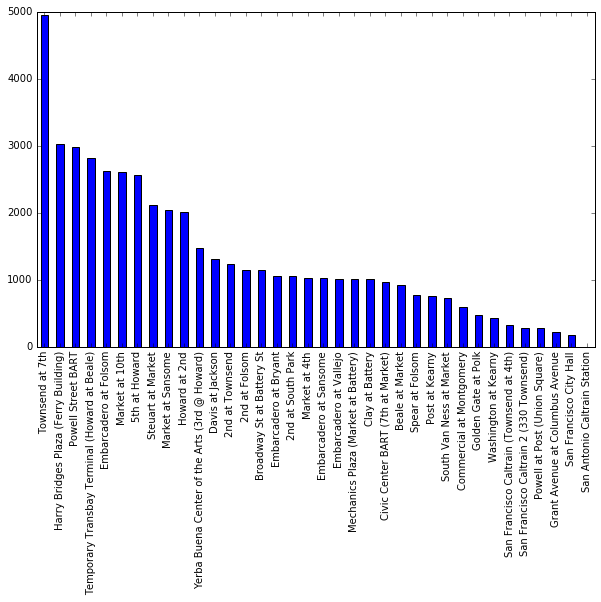

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6));
stationfq = pd.DataFrame(sffromcaltripsgrpbyend.collect(), columns = ['End_station', 'End_terminal','cnt'])
stationfq['cnt'][:100].plot(kind='bar')
ax.set_xticklabels(stationfq['End_station'][:100])